## Dog breed classifer

Author: Meyi D.

OpenClassrooms/Centrale Supélec

- Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Imports

In [30]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

#from skimage.io import imread
#from skimage.transform import resize
from PIL import Image, ImageOps, ImageFilter
#from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.preprocessing.image import *

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

## Data exploration and reduction to 10 breeds

In [3]:
# Number of breeds

breed_list = os.listdir("/content/drive/MyDrive/input/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/drive/MyDrive/input/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [4]:
# Reducing to 10 breeds

num_classes = len(breed_list[:10])
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list[:10]:
    n_total_images += len(os.listdir("/content/drive/MyDrive/input/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

10 breeds
1837 images


In [5]:
# Mapping of labels and numbers
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list[:10]):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [ ]:
# Picture visualization
def show_dir_images(breed, n_to_show, img_dir):
    plt.figure(figsize=(16,16))
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085936-Maltese_dog


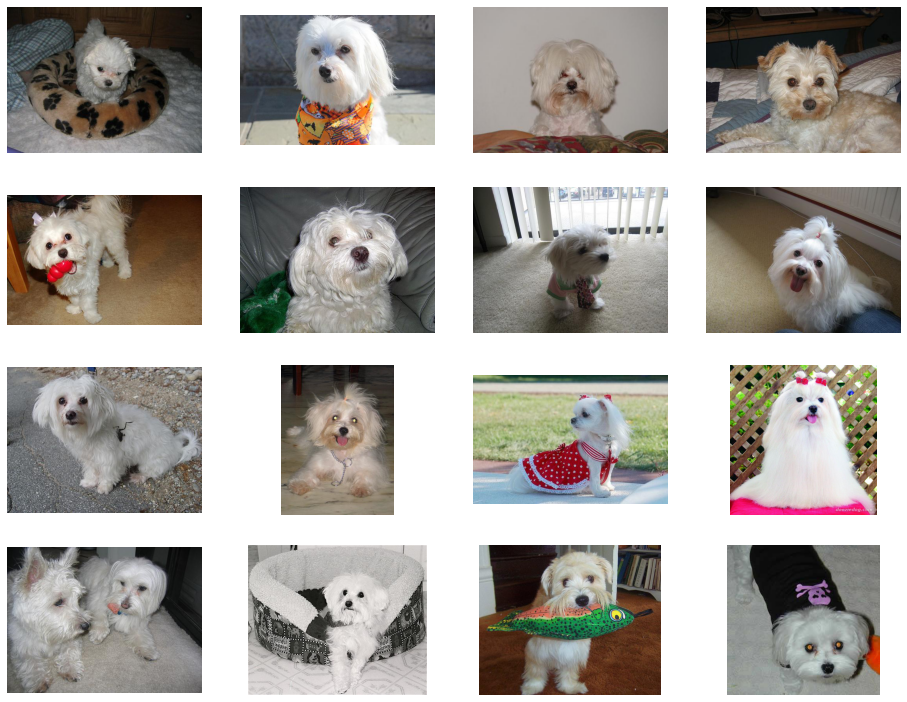

In [ ]:
print(breed_list[0])
img_dir = "/content/drive/MyDrive/input/images/Images/{}/".format(breed_list[0])
show_dir_images(breed_list[0], 16, img_dir)

In [ ]:
# Cropping images to the same size, without pre-processing
%%time

os.mkdir('/content/drive/MyDrive/data_raw')
for breed in breed_list[:10]:
    os.mkdir('/content/drive/MyDrive/data_raw/' + breed)

CPU times: user 304 µs, sys: 1.96 ms, total: 2.27 ms
Wall time: 18.3 ms


In [ ]:

print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('/content/drive/MyDrive/data_raw'))))

Created 10 folders to store cropped images of the different breeds.


In [ ]:
for breed in os.listdir('/content/drive/MyDrive/data_raw'):
    for file in os.listdir('/content/drive/MyDrive/input/annotation/Annotation/{}'.format(breed)):
        img = Image.open('/content/drive/MyDrive/input/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/content/drive/MyDrive/input/annotation/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.resize((224, 224))
        img.save('/content/drive/MyDrive/data_raw/' + breed + '/' + file + '.jpg')

n02085936-Maltese_dog


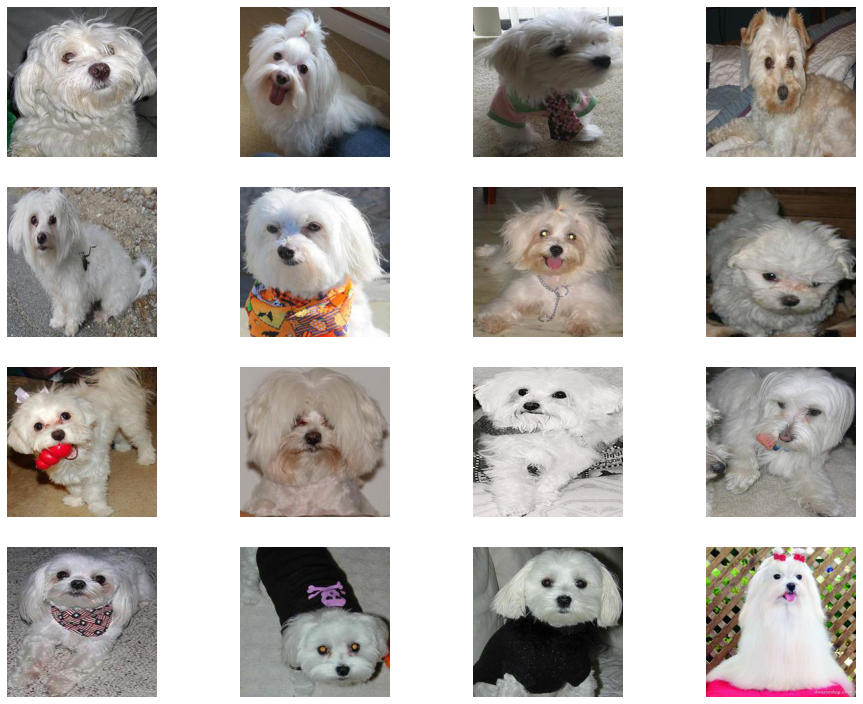

In [ ]:
print(breed_list[0])
img_dir = "/content/drive/MyDrive/data_raw/{}/".format(breed_list[0])
show_dir_images(breed_list[0], 16, img_dir)

## Inputs and outputs preparation

In [ ]:
def paths_and_labels_raw():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list[:10]:
        base_name = "/content/drive/MyDrive/data_raw/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths_raw, labels_raw, targets_raw = paths_and_labels_raw()

assert len(paths_raw) == len(labels_raw)
assert len(paths_raw) == len(targets_raw)

targets_raw = keras.utils.to_categorical(targets_raw, num_classes=num_classes)

In [ ]:
breed_list[:10]

['n02085936-Maltese_dog',
 'n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086079-Pekinese',
 'n02087046-toy_terrier',
 'n02086910-papillon',
 'n02087394-Rhodesian_ridgeback',
 'n02089973-English_foxhound']

 ## Train/test split

In [ ]:
train_data_dir = "/content/drive/MyDrive/data_raw"
img_width = 224
img_height = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2) # set validation split

train_generator_raw = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

validation_generator_raw = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1474 images belonging to 10 classes.
Found 363 images belonging to 10 classes.


## VGG16

In [25]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [26]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [27]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting 
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

Reducing learning rate when the accuracy has stopped improving

In [28]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.6,
                              patience=8, 
                              verbose=1, 
                              mode='max', 
                              min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', 
                             monitor= 'val_accuracy', 
                             mode= 'max',
                             save_best_only = True, verbose= 1)

In [31]:
from tensorflow.keras import layers, models, Model, optimizers

In [ ]:
#Compile model
learning_rate= 5e-5
nb_epochs = 10
transfer_model.compile(loss="categorical_crossentropy", 
                       optimizer=optimizers.Adam(lr=learning_rate), 
                       metrics=["accuracy"])

#Fit model
history = transfer_model.fit_generator(train_generator_raw, 
                                       steps_per_epoch = train_generator_raw.samples // batch_size,
                                       validation_data = validation_generator_raw, 
                                       validation_steps = validation_generator_raw.samples // batch_size,
                                       epochs = nb_epochs, 
                                       shuffle=True, 
                                       callbacks=[lr_reduce],
                                       verbose=1)

Epoch 1/10
46/46 [==============================] - 938s 20s/step - loss: 2.0618 - accuracy: 0.2497 - val_loss: 1.5054 - val_accuracy: 0.4744
Epoch 2/10
46/46 [==============================] - 939s 20s/step - loss: 1.2324 - accuracy: 0.5735 - val_loss: 1.0156 - val_accuracy: 0.6165
Epoch 3/10
46/46 [==============================] - 939s 20s/step - loss: 0.8396 - accuracy: 0.7074 - val_loss: 0.8266 - val_accuracy: 0.6932
Epoch 4/10
46/46 [==============================] - 936s 20s/step - loss: 0.5513 - accuracy: 0.8100 - val_loss: 0.8128 - val_accuracy: 0.7216
Epoch 5/10
46/46 [==============================] - 936s 20s/step - loss: 0.3299 - accuracy: 0.8925 - val_loss: 0.8222 - val_accuracy: 0.7188
Epoch 6/10
46/46 [==============================] - 938s 20s/step - loss: 0.2192 - accuracy: 0.9279 - val_loss: 0.8275 - val_accuracy: 0.7216
Epoch 7/10
46/46 [==============================] - 938s 20s/step - loss: 0.1210 - accuracy: 0.9626 - val_loss: 0.7979 - val_accuracy: 0.7273
Epoch 

In [ ]:
#Problème : Temps de computation très important malgré le petit jeu de données, on réalise donc le préprocessing des images

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


## Image preprocessing

- Equalization, 
- Cropping, 
- Noise cancelling(Gaussian filter), 
- Rescaling

In [ ]:
%%time

os.mkdir('/content/drive/MyDrive/data')
for breed in breed_list[:10]:
    os.mkdir('/content/drive/MyDrive/data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('/content/drive/MyDrive/input/annotation/Annotation/{}'.format(breed)):
        img = Image.open('/content/drive/MyDrive/input/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/content/drive/MyDrive/input/annotation/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img = ImageOps.equalize(img)
        img = img.filter(ImageFilter.BLUR)
        img.save('/content/drive/MyDrive/data/' + breed + '/' + file + '.jpg')

Created 10 folders to store cropped images of the different breeds.
CPU times: user 22.9 s, sys: 1.68 s, total: 24.6 s
Wall time: 11min 36s


n02085936-Maltese_dog


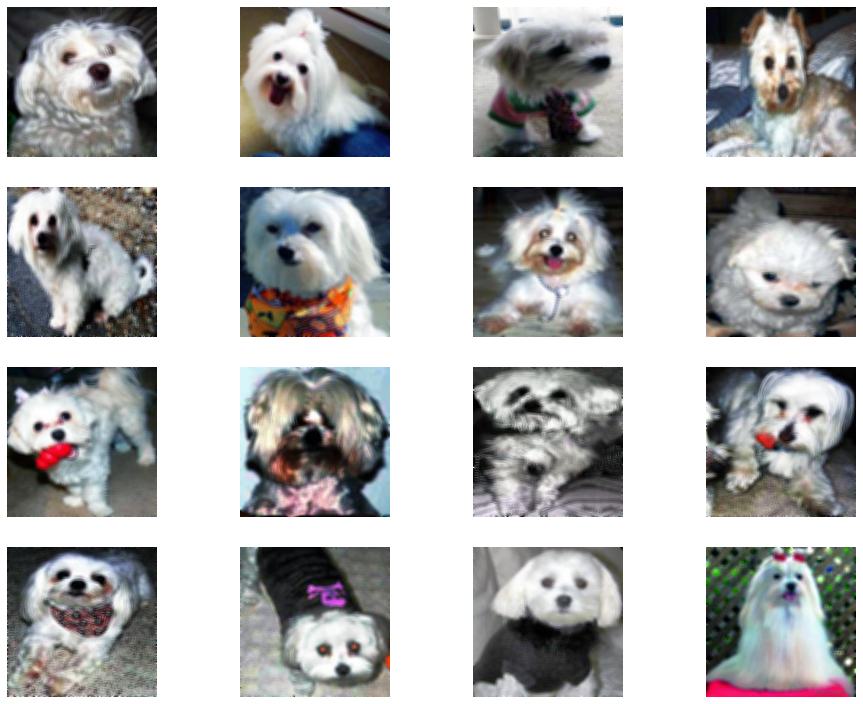

In [ ]:
print(breed_list[0])
img_dir = "/content/drive/MyDrive/data/{}/".format(breed_list[0])
show_dir_images(breed_list[0], 16, img_dir)

## Inputs and outputs preparation

In [6]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list[:10]:
        base_name = "/content/drive/MyDrive/data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = keras.utils.to_categorical(targets, num_classes=num_classes)

## Train test split

In [7]:
train_data_dir = "/content/drive/MyDrive/data"
img_width = 224
img_height = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1474 images belonging to 10 classes.
Found 363 images belonging to 10 classes.


## VGG16 

In [ ]:
#Compile model
learning_rate= 5e-5
nb_epochs = 10
transfer_model.compile(loss="categorical_crossentropy", 
                       optimizer=optimizers.Adam(lr=learning_rate), 
                       metrics=["accuracy"])

#Fit model
history = transfer_model.fit_generator(train_generator, 
                                       steps_per_epoch = train_generator.samples // batch_size,
                                       validation_data = validation_generator, 
                                       validation_steps = validation_generator.samples // batch_size,
                                       epochs = nb_epochs, 
                                       shuffle=True, 
                                       callbacks=[lr_reduce],
                                       verbose=1)

Epoch 1/10
46/46 [==============================] - 813s 17s/step - loss: 2.2119 - accuracy: 0.1949 - val_loss: 1.8196 - val_accuracy: 0.4091
Epoch 2/10
46/46 [==============================] - 758s 17s/step - loss: 1.5693 - accuracy: 0.4355 - val_loss: 1.4375 - val_accuracy: 0.4801
Epoch 3/10
46/46 [==============================] - 769s 17s/step - loss: 1.1416 - accuracy: 0.6047 - val_loss: 1.2938 - val_accuracy: 0.5455
Epoch 4/10
46/46 [==============================] - 772s 17s/step - loss: 0.8050 - accuracy: 0.7330 - val_loss: 1.1598 - val_accuracy: 0.6023
Epoch 5/10
46/46 [==============================] - 769s 17s/step - loss: 0.5413 - accuracy: 0.8190 - val_loss: 1.0839 - val_accuracy: 0.6051
Epoch 6/10
46/46 [==============================] - 766s 17s/step - loss: 0.5251 - accuracy: 0.8308 - val_loss: 1.0771 - val_accuracy: 0.6278
Epoch 7/10
46/46 [==============================] - 768s 17s/step - loss: 0.2621 - accuracy: 0.9189 - val_loss: 1.2048 - val_accuracy: 0.6449
Epoch 

## Online data augmentation (flow_from_directory)

In [8]:
train_data_dir = "/content/drive/MyDrive/data"
img_width = 224
img_height = 224
batch_size = 32

train_datagen_mc = ImageDataGenerator(rescale=1./255,
                                   zca_whitening=True,
                                   horizontal_flip=True, 
                                   validation_split=0.2) # set validation split

train_generator_1 = train_datagen_mc.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 

validation_generator_1 = train_datagen_mc.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1474 images belonging to 10 classes.
Found 363 images belonging to 10 classes.


## VGG16

In [32]:
#Compile model
learning_rate= 5e-5
nb_epochs = 10
transfer_model.compile(loss="categorical_crossentropy", 
                       optimizer=optimizers.Adam(lr=learning_rate), 
                       metrics=["accuracy"])

#Fit model
history = transfer_model.fit_generator(train_generator_1, 
                                       steps_per_epoch = train_generator_1.samples // batch_size,
                                       validation_data = validation_generator_1, 
                                       validation_steps = validation_generator_1.samples // batch_size,
                                       epochs = nb_epochs, 
                                       shuffle=True, 
                                       callbacks=[lr_reduce],
                                       verbose=1)

Epoch 1/10
46/46 [==============================] - 955s 21s/step - loss: 2.2326 - accuracy: 0.1935 - val_loss: 2.0450 - val_accuracy: 0.2472
Epoch 2/10
46/46 [==============================] - 951s 21s/step - loss: 1.7656 - accuracy: 0.3641 - val_loss: 1.4838 - val_accuracy: 0.4943
Epoch 3/10
46/46 [==============================] - 947s 21s/step - loss: 1.3587 - accuracy: 0.5229 - val_loss: 1.2523 - val_accuracy: 0.5682
Epoch 4/10
46/46 [==============================] - 947s 21s/step - loss: 1.0628 - accuracy: 0.6352 - val_loss: 1.2094 - val_accuracy: 0.5881
Epoch 5/10
46/46 [==============================] - 951s 21s/step - loss: 0.8145 - accuracy: 0.7268 - val_loss: 1.0656 - val_accuracy: 0.5994
Epoch 6/10
46/46 [==============================] - 946s 21s/step - loss: 0.7314 - accuracy: 0.7503 - val_loss: 1.0810 - val_accuracy: 0.6335
Epoch 7/10
46/46 [==============================] - 946s 21s/step - loss: 0.5388 - accuracy: 0.8176 - val_loss: 1.0790 - val_accuracy: 0.6222
Epoch 

## ResNet50

In [ ]:
input_tensor = keras.Input(shape=(224,224,3)) #uniformiser shape
res_model = keras.applications.ResNet50(include_top=False,
                          weights="imagenet",
                          input_tensor=input_tensor)
for layer in res_model.layers[:143]:
    layer.trainable = False
    
for i,layer in enumerate (res_model.layers):
    print(i, layer.name, "-", layer.trainable)
        
transfer_model_1 = keras.models.Sequential()
transfer_model_1.add(res_model)
transfer_model_1.add(keras.layers.Flatten())
transfer_model_1.add(keras.layers.Dense(10, activation='softmax'))

#maybe add layers

0 input_3 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
check_point = keras.callbacks.ModelCheckpoint(filepath = "",
                                             monitor="val_acc",
                                             mode="max",
                                             save_best_only=True,
                                             )

In [ ]:
nb_epochs = 10

from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.6,
                              patience=8, 
                              verbose=1, 
                              mode='max', 
                              min_lr=5e-5)

transfer_model_1.compile(loss='categorical_crossentropy',
             optimizer=keras.optimizers.RMSprop(lr=2e-5),
             metrics=['accuracy'])
#Fit model
history_1 = transfer_model_1.fit_generator(train_generator, 
                                       steps_per_epoch = train_generator.samples // batch_size,
                                       validation_data = validation_generator, 
                                       validation_steps = validation_generator.samples // batch_size,
                                       epochs = nb_epochs, 
                                       shuffle=True, 
                                       callbacks=[lr_reduce],
                                       verbose=1)

transfer_model_1.summary()
#model.save(...?) ???
#ajouter le plot ici aussi

Epoch 1/10
46/46 [==============================] - 416s 9s/step - loss: 3.3896 - accuracy: 0.2011 - val_loss: 3.3587 - val_accuracy: 0.0909
Epoch 2/10
46/46 [==============================] - 393s 9s/step - loss: 2.3437 - accuracy: 0.3086 - val_loss: 3.5069 - val_accuracy: 0.0852
Epoch 3/10
46/46 [==============================] - 395s 9s/step - loss: 2.0917 - accuracy: 0.3363 - val_loss: 3.6449 - val_accuracy: 0.0881
Epoch 4/10
46/46 [==============================] - 399s 9s/step - loss: 1.7927 - accuracy: 0.4015 - val_loss: 3.6796 - val_accuracy: 0.0852
Epoch 5/10
46/46 [==============================] - 402s 9s/step - loss: 1.6350 - accuracy: 0.4584 - val_loss: 2.9201 - val_accuracy: 0.0852
Epoch 6/10
46/46 [==============================] - 403s 9s/step - loss: 1.4465 - accuracy: 0.5277 - val_loss: 2.3303 - val_accuracy: 0.2244
Epoch 7/10
46/46 [==============================] - 402s 9s/step - loss: 1.3382 - accuracy: 0.5721 - val_loss: 2.3101 - val_accuracy: 0.2500
Epoch 8/10
46

## CNN implementation

In [9]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 6.2 MB/s 


In [10]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch, Hyperband

In [11]:
def build_model_CNN(hp):
  learning_rate_hp = hp.Choice("learning_rate", values=[1e-2, 1e-3])
  kernel_size_hp = hp.Choice("kernel_size", values=[3,5])
  loss = "categorical_crossentropy"
  model = keras.Sequential()
  model.add(layers.Conv2D(64, kernel_size=kernel_size_hp, activation='relu',
                          input_shape=(224, 224, 3), strides=2, padding = 'valid'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(96, kernel_size=kernel_size_hp, activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(112, kernel_size=kernel_size_hp, activation='relu', padding ='same'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(112, kernel_size=kernel_size_hp, activation='relu', padding ='same'))
  model.add(layers.MaxPooling2D(pool_size=2))
  model.add(layers.Conv2D(112,kernel_size=kernel_size_hp, activation='relu',padding ='same'))
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation="softmax"))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_hp),
  loss=loss,
  metrics=["accuracy"])
  return model

In [12]:
tuner = Hyperband(build_model_CNN,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/',
                     project_name='Dog_breed_classification')


In [14]:
tuner.search_space_summary()


Search space summary
Default search space size: 2
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}


In [15]:
epochs_hp = 10
tuner.search(train_generator, epochs=epochs_hp, validation_data=validation_generator)

Trial 3 Complete [00h 24m 47s]
val_accuracy: 0.13774104416370392

Best val_accuracy So Far: 0.3319559246301651
Total elapsed time: 02h 24m 15s
INFO:tensorflow:Oracle triggered exit


In [17]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal kernel_size is {best_hps.get('kernel_size')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.""") 


The hyperparameter search is complete. The optimal kernel_size is 5 and the optimal learning rate for the optimizer
is 0.001.


In [19]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model_CNN = tuner.hypermodel.build(best_hps)
history = model_CNN.fit_generator(train_generator, epochs=10, validation_data=validation_generator)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/10
47/47 [==============================] - 153s 3s/step - loss: 2.3093 - accuracy: 0.1214 - val_loss: 2.2958 - val_accuracy: 0.1405
Epoch 2/10
47/47 [==============================] - 152s 3s/step - loss: 2.2904 - accuracy: 0.1370 - val_loss: 2.2835 - val_accuracy: 0.1570
Epoch 3/10
47/47 [==============================] - 153s 3s/step - loss: 2.1949 - accuracy: 0.2069 - val_loss: 2.1425 - val_accuracy: 0.2479
Epoch 4/10
47/47 [==============================] - 152s 3s/step - loss: 2.0686 - accuracy: 0.2503 - val_loss: 2.0765 - val_accuracy: 0.2259
Epoch 5/10
47/47 [==============================] - 152s 3s/step - loss: 2.0108 - accuracy: 0.2890 - val_loss: 2.0114 - val_accuracy: 0.2782
Epoch 6/10
47/47 [==============================] - 152s 3s/step - loss: 1.9237 - accuracy: 0.3284 - val_loss: 2.0310 - val_accuracy: 0.2727
Epoch 7/10
47/47 [==============================] - 152s 3s/step - loss: 1.8402 - accuracy: 0.3623 - val_loss: 2.0195 - val_accuracy: 0.3251
Epoch 8/10
47

In [20]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit_generator(train_generator, epochs=best_epoch, validation_data=validation_generator)


Epoch 1/10
47/47 [==============================] - 153s 3s/step - loss: 2.3015 - accuracy: 0.1289 - val_loss: 2.2995 - val_accuracy: 0.1377
Epoch 2/10
47/47 [==============================] - 152s 3s/step - loss: 2.2957 - accuracy: 0.1398 - val_loss: 2.2428 - val_accuracy: 0.1515
Epoch 3/10
47/47 [==============================] - 152s 3s/step - loss: 2.1700 - accuracy: 0.2239 - val_loss: 2.1213 - val_accuracy: 0.2479
Epoch 4/10
47/47 [==============================] - 152s 3s/step - loss: 2.0587 - accuracy: 0.2619 - val_loss: 2.0625 - val_accuracy: 0.2782
Epoch 5/10
47/47 [==============================] - 152s 3s/step - loss: 1.9805 - accuracy: 0.2904 - val_loss: 2.0102 - val_accuracy: 0.2424
Epoch 6/10
47/47 [==============================] - 151s 3s/step - loss: 1.9297 - accuracy: 0.3087 - val_loss: 1.9689 - val_accuracy: 0.3003
Epoch 7/10
47/47 [==============================] - 152s 3s/step - loss: 1.8209 - accuracy: 0.3616 - val_loss: 1.9935 - val_accuracy: 0.2562
Epoch 8/10
47

In [21]:
perso_model = tuner.get_best_models(num_models=1)

In [22]:
tuner.results_summary()


Results summary
Results in /content/drive/MyDrive/Dogs_Breed_Classification
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
kernel_size: 5
Score: 0.3319559246301651
Trial summary
Hyperparameters:
learning_rate: 0.01
kernel_size: 5
Score: 0.13774104416370392
Trial summary
Hyperparameters:
learning_rate: 0.01
kernel_size: 3
Score: 0.13774104416370392


In [ ]:
#RESET

!rm -rf data/* 

# gradio


In [23]:
!pip install gradio

     |████████████████████████████████| 3.4 MB 36.8 MB/s 
     |████████████████████████████████| 206 kB 55.6 MB/s 
     |████████████████████████████████| 1.9 MB 64.3 MB/s 
     |████████████████████████████████| 961 kB 55.2 MB/s 
     |████████████████████████████████| 3.5 MB 71.4 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=fa0ac8c69ccf2a79e397fee7eadbb757c7dd62ece652cafe4ab50463a395c35a
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=8381b207355edf1a9f43b652358c9e7d7607740cab0f3db77a4be9c15d913be1
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
import gradio
# Load the model
model_dog_breeds = transfer_model

#Load the labels
labels_dog_breeds = breed_list[:10]



In [ ]:
#------------------#

# Function for preprocessing an image and predicting the dog breed
def classify_image(image_):
    img = image_.reshape((-1,224, 224, 3))
    prediction = model_dog_breeds.predict(img).flatten()

    return {labels_dog_breeds[i]: float(prediction[i]) for i in range(10)}

# Define the inputs, outputs
image = gradio.inputs.Image(shape=(224,224))
label = gradio.outputs.Label(num_top_classes=3)



In [ ]:
#------------------#

# Launch the application
gradio.Interface(
    fn=classify_image,
    inputs=image,
    outputs=label,
    title="Image classification - limited to 10 dog breeds",
).launch(debug=False)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://36149.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7875/',
 'https://36149.gradio.app')